# ♟️ Chess Pieces Detection - Grad-CAM

Author: [Martin Tomov](https://martintomov.com) - @martintmv <br> Dataset: [Kaggle Chess Pieces Detection](https://www.kaggle.com/datasets/anshulmehtakaggl/chess-pieces-detection-images-dataset)

The dataset chosen for this assignment is a collection of 651 chess piece images, sourced from Kaggle's "Chess Pieces Detection Images Dataset".

This notebook was created in Google Colab in attempt to utilise the T4 GPU.

#### ❓ Why the Chess Pieces Dataset is Suitable for CNNs?

1️⃣. <b>Variety of Classes:</b> <br>It includes images categorised into five different chess pieces - Pawn, Queen, Rook, Bishop, and Knight. This variety allows for a comprehensive classification challenge.

2️⃣. <b>Real-world Application:</b> <br> Chess piece recognition is a cool real-world task. It's useful for analyzing games, online chess platforms, and educational tools.

3️⃣. <b>Dataset Size and Complexity:</b> <br> This size is manageable yet sufficiently challenging for training a robust model, making it ideal for educational purposes and for demonstrating the effectiveness of transfer learning where the model leverages pre-learned patterns from a larger dataset.

#### ❓ Approach

Given the dataset's characteristics, my approach will leverage a pre-trained Convolutional Neural Network (CNN), specifically the VGG16 model, known for its performance in image classification tasks. The VGG16 model, pre-trained on the ImageNet dataset, provides a robust set of features for image recognition that we can fine-tune for our specific task of chess piece classification.

1️⃣. <b>Preprocessing:</b> <br> Making images ready for the model by resizing and adjusting them.

2️⃣. <b>Customizing the Model:</b> <br> Add some new layers on top of VGG16 to make it work for recognizing chess pieces. These new layers help the model understand our specific task better.

3️⃣. <b>Training, Testing and Evaluating Performance:</b> <br> Train the model and check how well it's doing using K-Fold cross-validation. This helps to make sure the model works well with new images too. Next, a confusion matrix to see how well the model recognizes each chess piece. Finally, show some example images to see where the model does well and where it needs improvement.

#### ❓ Why VGG16 and not VGG19

The primary differnece between VGG16 and VGG19 lies in the number of layers, where VGG19 is more complex but may face challenges related to overfitting compared to the slightly simpler yet high-performing VGG16 architecture. VGG16 tends to perform better than VGG19 for smaller datasets. The simplicity of VGG16 makes it more suitable for smaller datasets, as it is less prone to overfitting compared to VGG19.


# Step 1. Imports
First, I need to import necessary libraries.

In [ ]:
# Importing libraries
# ------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import pathlib
import os
import seaborn as sns

from google.colab import drive
from sklearn.model_selection import KFold, train_test_split
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

# Step 2. Load Data with Pandas
In this step, I'm loading the dataset from my Google Drive. The dataset consists of images of chess pieces, and we're interested in the type of piece each image represents.

In [ ]:
from pathlib import Path
drive.mount('/content/drive')

# Define the path to the dataset
data_path = Path('/content/drive/MyDrive/chessdata')

# Collect all jpg image paths
img_paths = list(data_path.glob('**/*.jpg'))

# Extract labels from the path
img_labels = [path.parent.name for path in img_paths]

# Create a DataFrame
img_df = pd.DataFrame({
    'Path': img_paths,
    'Label': img_labels
})

# Shuffle the DataFrame to ensure a good mix of data points
img_df = img_df.sample(frac=1).reset_index(drop=True)

# Display the first few entries of the DataFrame
print(img_df.head())


Mounted at /content/drive
                                                Path           Label
0  /content/drive/MyDrive/chessdata/Rook-resize/0...     Rook-resize
1  /content/drive/MyDrive/chessdata/bishop_resize...  bishop_resized
2  /content/drive/MyDrive/chessdata/bishop_resize...  bishop_resized
3  /content/drive/MyDrive/chessdata/knight-resize...   knight-resize
4  /content/drive/MyDrive/chessdata/pawn_resized/...    pawn_resized


### Explore Data Distribution

Before diving into model building, it's crucial to understand the distribution of classes in our dataset. Here, I visualize the frequency of each chess piece class to ensure that our model isn't biased towards any particular class during training. A balanced dataset helps in creating a model that performs equally well across all classes.


Label
knight-resize     174
bishop_resized    141
Rook-resize       139
Queen-Resized     115
pawn_resized       82
Name: count, dtype: int64


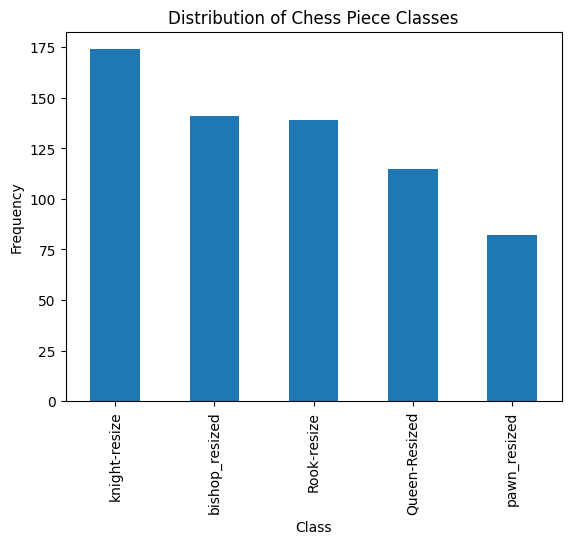

In [ ]:
# Count the number of images per label
label_counts = img_df['Label'].value_counts()
print(label_counts)

# Visualize the distribution of classes
label_counts.plot(kind='bar')
plt.title('Distribution of Chess Piece Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### Visualize Sample Images

To get a better sense of the data we're working with, I'll look at a few sample images from each class. This helps me verify that the images have been loaded correctly and gives us an idea about the variety and characteristics of the chess pieces that our model will learn to recognise.


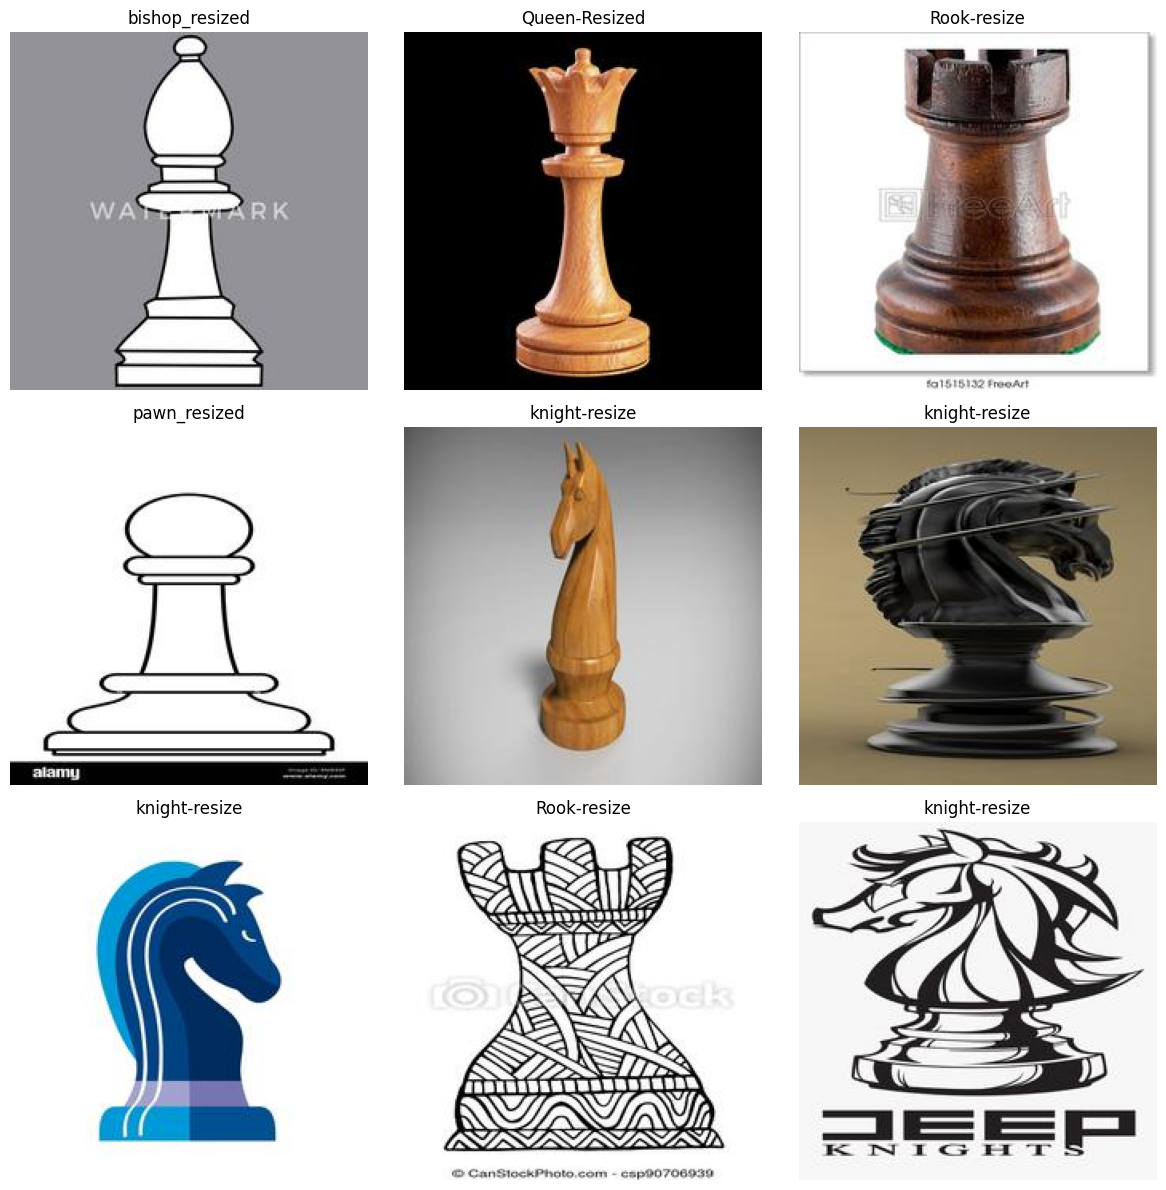

In [ ]:
from PIL import Image

# Display sample images from each class
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i, (path, label) in enumerate(img_df.sample(9).values):
    img = Image.open(path)
    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Step 3: Split Data into Training and Testing Sets

The dataset is divided into a larger training set for the model to learn from, and a smaller test set to evaluate the model's performance on data it hasn't seen before. This split is essential for validating the model's ability to generalize.

I resize images to 224x224, which is a standard size for models like VGG16.

The `ImageDataGenerator` class is a workhorse for augmentation, handling rescaling (normalizing pixel values), horizontal flipping, and other transformations on-the-fly.

The `validation_split` parameter earmarks 20% of the images for validation purposes, which is useful when we want to assess the model during training.

In [ ]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(img_df, test_size=0.2, random_state=42, stratify=img_df['Label'])

print(f"Training set size: {train_df.shape[0]}")
print(f"Testing set size: {test_df.shape[0]}")

Training set size: 520
Testing set size: 131


In [ ]:
# Define image dimensions for VGG16
width, height = 224, 224

# Setup real-time data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1/255.0,  # Normalize image pixel values to [0,1]
    horizontal_flip=True, # Augment data by flipping images horizontally
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.3,
    validation_split=0.2
)

# Step 4: Model with VGG16

Using transfer learning, I load the VGG16 model pretrained on ImageNet, without its classification layers (top layers), to leverage its pre-trained convolutional base, ensuring these layers are non-trainable to preserve their learned features.

A new top section is added, designed specifically for the task of classifying five chess piece categories. This includes a Flatten layer, Dense layers with ReLU and softmax activations, and Dropout for regularization.

Then I compile this modified model with a lower learning rate to fine-tune the weights in the newly added layers without significant changes to the pre-trained base.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
    x = Dense(5, activation='softmax')(x)  # Final layer with softmax activation for 5 classes

    # Combine the base model with the top layers
    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = (224, 224, 3)
model = create_model(input_shape)

# display the structure of the model
model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

# Step 5: Grad-CAM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    # I add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This vector is a 2D array with shape
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, I will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Step 6: K-Fold Cross-Validation Setup

This method splits data into 'K' folds, iteratively training the model `5` times with a different fold as the validation set each time. This reduces overfitting and biases in evaluation metrics.

In [ ]:
from sklearn.model_selection import StratifiedKFold
img_df['Path'] = img_df['Path'].astype(str)  # Convert 'Path' column to string

# Parameters
n_splits = 5
epochs = 10
batch_size = 32

# Preparation for K-Fold
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_no = 1
input_shape = (224, 224, 3)

# Convert labels to numerical labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
img_df['Encoded_Labels'] = le.fit_transform(img_df['Label'])
labels = img_df['Encoded_Labels'].values

for train, test in kfold.split(np.zeros(len(labels)), labels):
    train_generator = datagen.flow_from_dataframe(img_df.iloc[train], directory=None,
                                                  x_col='Path', y_col='Label', target_size=input_shape[:2],
                                                  class_mode='categorical', batch_size=batch_size)
    validation_generator = datagen.flow_from_dataframe(img_df.iloc[test], directory=None,
                                                        x_col='Path', y_col='Label', target_size=input_shape[:2],
                                                        class_mode='categorical', batch_size=batch_size)
    # Reinitialize the model (to start fresh for each fold)
    model = create_model(input_shape)

    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

    scores = model.evaluate(validation_generator)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    fold_no += 1

Found 520 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
Epoch 1/10
17/17 [==============================] - 172s 10s/step - loss: 1.7611 - accuracy: 0.3077 - val_loss: 1.1056 - val_accuracy: 0.5573
Epoch 2/10
17/17 [==============================] - 8s 480ms/step - loss: 1.1679 - accuracy: 0.5115 - val_loss: 0.9959 - val_accuracy: 0.6260
Epoch 3/10
17/17 [==============================] - 8s 472ms/step - loss: 0.9439 - accuracy: 0.6404 - val_loss: 0.8330 - val_accuracy: 0.7481
Epoch 4/10
17/17 [==============================] - 8s 469ms/step - loss: 0.8201 - accuracy: 0.7173 - val_loss: 0.6512 - val_accuracy: 0.8092
Epoch 5/10
17/17 [==============================] - 8s 489ms/step - loss: 0.6999 - accuracy: 0.7462 - val_loss: 0.6170 - val_accuracy: 0.7939
Epoch 6/10
17/17 [==============================] - 8s 476ms/step - loss: 0.6184 - accuracy: 0.7923 - val_loss: 0.6056 - val_accuracy: 0.7863
Epoch 7/10
17/17 [==========

# Step 7: Testing the model

With the model trained, it's time to put it to the test on unseen data. This is where we truly assess its performance.

- First, I confirm that all file paths in the `test_df` DataFrame are strings to ensure compatibility with our image data generator.
- Next, I set up a `test_generator`, which will feed the test images to our model without shuffling to preserve the order—this is key for an accurate evaluation.
- Using this generator, we evaluate the model to obtain the final loss and accuracy metrics on the test data, giving us insight into how well the model generalises beyond the data it was trained on.


In [ ]:
# Define the ImageDataGenerator for the test set (should not include augmentation)
test_datagen = ImageDataGenerator(
    rescale=1/255.0
)

# Ensure the 'Path' column is of type string
test_df['Path'] = test_df['Path'].astype(str)

# Create the test_generator using the test_datagen
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,  # Experimenting with 16 also
    class_mode='categorical',
    shuffle=False  # Important for evaluation to match predictions with actual labels
)

Found 131 validated image filenames belonging to 5 classes.


In [ ]:
# Evaluate the model on the test set
eval_results = model.evaluate(test_generator)
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")


5/5 [==============================] - 1s 71ms/step - loss: 0.2506 - accuracy: 0.9389
Test Loss: 0.25063949823379517, Test Accuracy: 0.9389312863349915


# Step 8: Visualizing the Results and Confusion Matrix

### Visualizing Training Results

After training the model, we must look at its performance across epochs. These plots help us understand the learning trajectory of the model and pinpoint issues such as overfitting or underfitting.

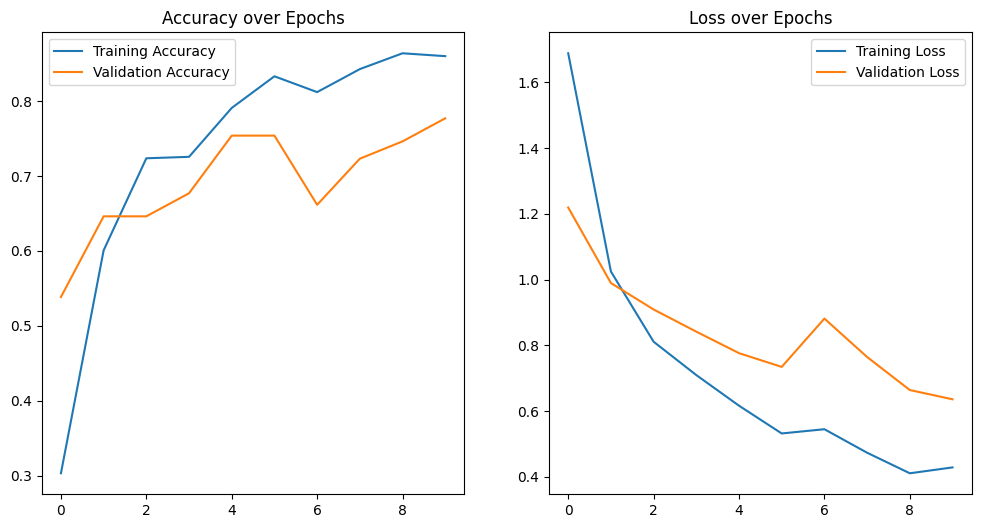

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

### Confusion Matrix

A crucial part of model evaluation, especially in classification tasks, is understanding how the model performs for each class. This is where the confusion matrix comes into play. It allows us to visualize the model's performance across all classes, showing where it may confuse one class for another.

Correct predictions are found along the diagonal, while off-diagonal entries indicate misclassifications.


5/5 [==============================] - 1s 86ms/step


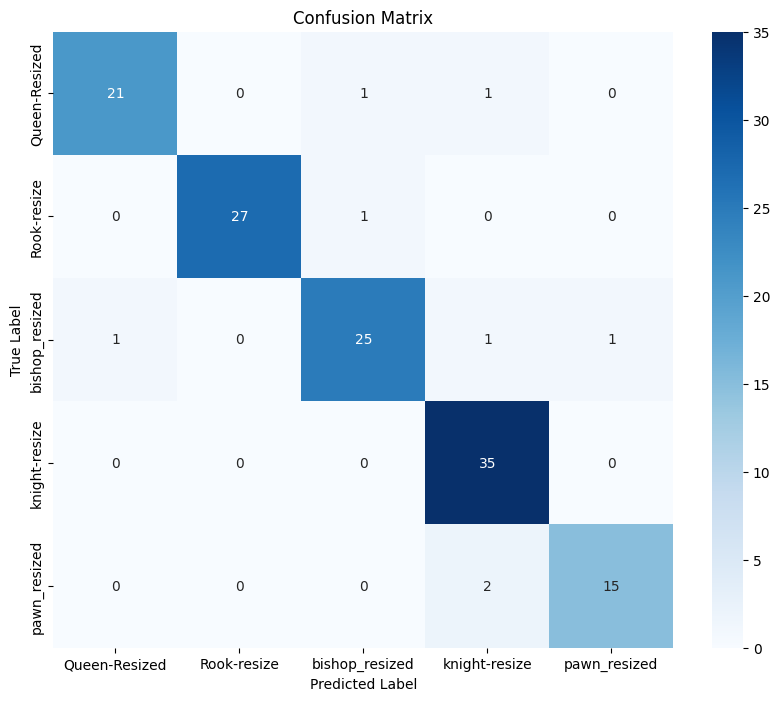

In [ ]:
# Predict the test dataset
test_predictions = model.predict(test_generator)
predicted_classes = np.argmax(test_predictions, axis=1)

# True labels
true_classes = test_generator.classes

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Step 9: Grad-Cam Visualization

1/1 [==============================] - 0s 26ms/step
Predicted class: knight-resize


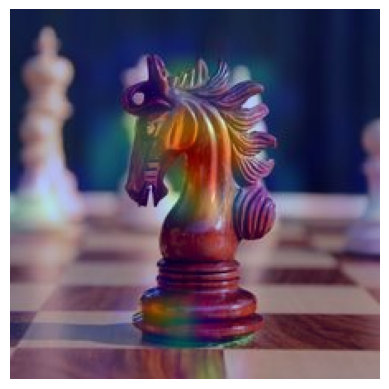

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

img_path = '/content/drive/MyDrive/chessdata/knight-resize/00000037_resized.jpg'

# Prepare the image
img_array = preprocess_input(get_img_array(img_path, img_size))

# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0], axis=-1)
predicted_class_name = le.classes_[predicted_class]
print(f"Predicted class: {predicted_class_name}")

# Generate class activation heatmap
last_conv_layer_name = 'block5_conv3'
classifier_layer_names = ['flatten', 'dense', 'dropout', 'dense_1']
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
cam_path = "cam.jpg"  # save the grad-cam image
alpha = 0.4

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.7):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    colormap = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = colormap(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

save_and_display_gradcam(img_path, heatmap, cam_path=cam_path, alpha=alpha)

# 🔍 Observations and Conclusions

The model's training showed a promising trajectory, with high accuracy levels and declining loss, although with slight signs of overfitting as evidenced by validation metrics. The confusion matrix revealed impressive classification rates, with minor confusions between similar-shaped pieces like rooks and queens.

### ⚙️ To improve:
- Regularization and early stopping may curb overfitting.
- Further hyperparameter tuning could refine performance.

> #### ✅ Overall, the model demonstrates a solid foundation in recognizing chess pieces with high accuracy. While there is room for improvement to address overfitting and enhance the model's ability to generalize, the current results are encouraging.

### 🚀 Knowledge and Skills I Acquired or Reinforced
- Understanding and applying transfer learning with VGG16
- Implementing K-Fold cross-validation for robust model evaluation
- Fine-tuning model architecture and parameters to improve classification performance
- Interpreting model performance through accuracy/loss graphs and confusion matrices
- Addressing class imbalance with data augmentation strategies

### 🔗 Sources:
- https://keras.io/guides/transfer_learning/
- https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md
- https://lambdalabs.com/blog/tensorflow-2-0-tutorial-04-early-stopping

